# Projet 1:

In [ ]:
# On importe les biblothèques nécessaires pour la suite

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf , pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,mean_absolute_error
import itertools
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
import seaborn as sns
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

On souhaite modéliser une série représentant la production mensuelle de bière en Australie entre janvier 1956 et février 1991.

Dans un premier temps, on se propose de chargées nos données dans un DataFrame, afin de visualiser à quoi ressemblent nos données.

In [ ]:
df = pd.read_csv("beer.txt", header = None, names = ['PMBA'])

On lit le fit le fichier, on remet en forme, et on nomme la colonne PMBA pour signifier : Production mensuelle de bière en Australlie

On regarde un bref aperçu de notre dataframe, on a 422 lignes signifiant -> on a la production de bière sur 422 mois donc sur 35 ans, cela correspond bien à nos attentes.

In [ ]:
df

,PMBA
0,93.2
1,96.0
2,95.2
3,77.1
4,70.9
...,...
417,193.8
418,208.4
419,197.0
420,164.0


In [ ]:
# Petite vérification que nous n'ayons pas de données manquantes, tout est OK
df.isna().sum()

PMBA    0
dtype: int64

In [ ]:
# Il nous faut transformer nos indices en les mois correspondants afin d'y voir plus clair

start_date = pd.to_datetime("1956-01-01")
end_date = pd.to_datetime("1991-02-01")
Mois = pd.date_range(start_date, end_date, freq="MS")

# On ajoute la série de dates comme une nouvelle colonne à notre DataFrame
df["Mois"] = Mois

# On définit la colonne "date" comme index de notre DataFrame
df.set_index("Mois", inplace=True)

# On affiche le résultat
df

,PMBA
Mois,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9
...,...
1990-10-01,193.8
1990-11-01,208.4
1990-12-01,197.0


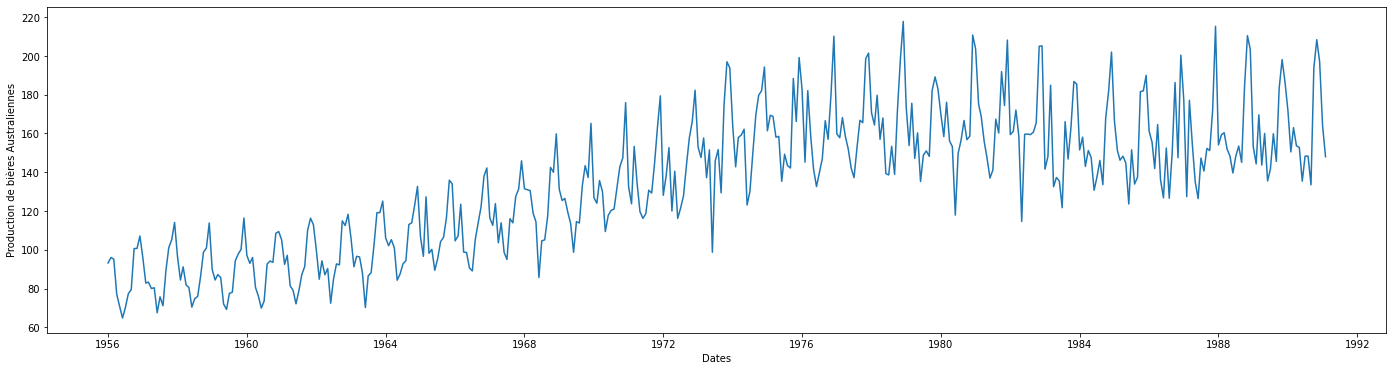

In [ ]:
# Maintenant que nos données sont traitées, on peut commencer par regarder l'allure de notre série
plt.figure(figsize=(24,6))
plt.plot(df)
plt.xlabel("Dates")
plt.ylabel("Production de bières Australiennes")
plt.show()

<ipython-input-79-88e0dc9c1951>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(df, model='multiplicative', freq = 12)


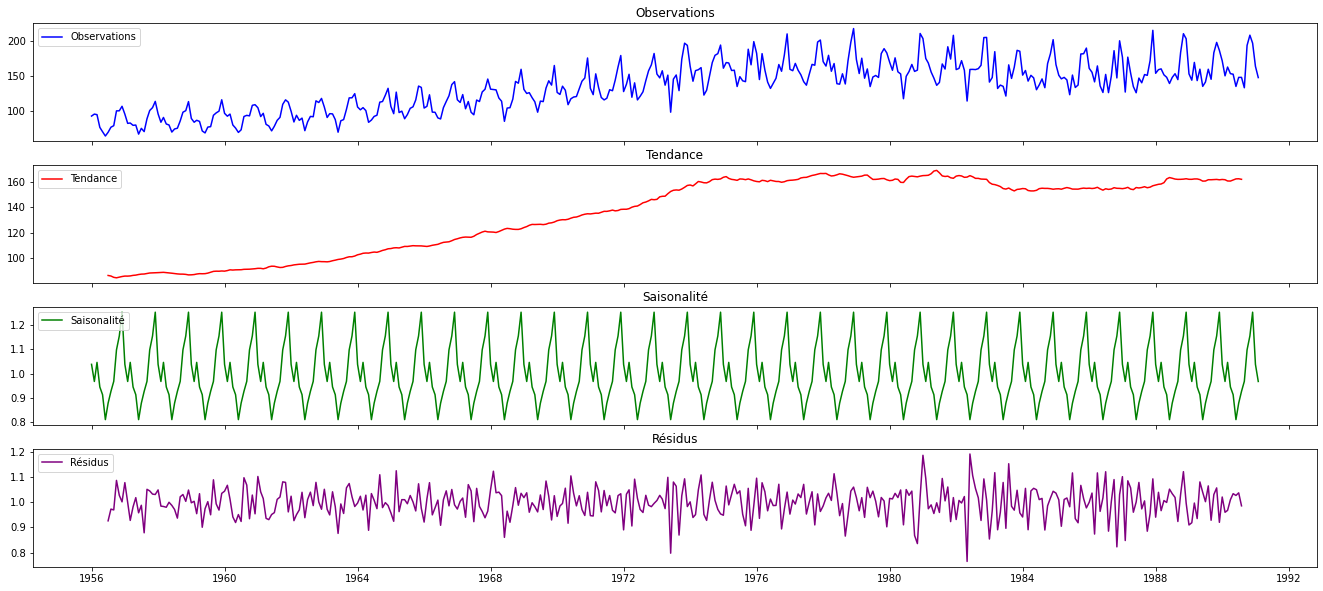

In [ ]:
# On voit dans un premier temps l'effet saisonnier de la production de bière, ainsi qu'une tendance à la hausse
# Afin de vérifier ces observations, on utilise la fonction seasonal decompose qui nous sort les différents indicateurs de tendances, saisonnalités... :

decomposition = seasonal_decompose(df, model='multiplicative', freq = 12)

fig, axes = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(23, 10))

# Plot les observations
axes[0].plot(df.index, df, label='Observations', color='blue')

# Plot la tendance
axes[1].plot(df.index, decomposition.trend, label='Tendance', color='red')

# Plot la saisonalité
axes[2].plot(df.index, decomposition.seasonal, label='Saisonalité', color='green')

# Plot les résidus
axes[3].plot(df.index, decomposition.resid, label='Résidus', color='purple')

# Set the titles for each subplot
axes[0].set_title('Observations')
axes[1].set_title('Tendance')
axes[2].set_title('Saisonalité')
axes[3].set_title('Résidus')

# Add a legend to the first subplot
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[3].legend(loc='upper left')

# Display the plot
plt.show()

In [ ]:
# Nos observations initiales étaient assez proches
# On observe : - une tendance à la hausse dans un premier temps puis qui fluctue/reste constante à partir de 1974
#              - une variance qui augmente au fur et à mesure des années
#              - une saisonalité prononcé qui se répète

# Tous ces éléments nous portent à croire que notre série n'est pas stationnaire, afin d'en être sûr, on se propose de faire un test de Dickey-Fuller Augmenté


result = adfuller(df)
print("Test de Dickey-Fuller Augmenté :")
print(f"Statistiques de test : {result[0]}")
print(f"p-value : {result[1]}")
print("Valeurs critiques :")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

Test de Dickey-Fuller Augmenté :
Statistiques de test : -1.8123779109436757
p-value : 0.3743339509962369
Valeurs critiques :
	1%: -3.44664043608676
	5%: -2.868720756230461
	10%: -2.5705951311145965


In [ ]:
# Le test de Dickey-Fuller augmenté a comme hypothèse nulle que la série temporelle a une racine unitaire, et donc qu'elle est non stationnaire.
# Si la p-valeur est inférieure à un seuil de signification de 0.05, on peut rejeter notre hypothèse nulle et conclure que la série est stationnaire.

# Dans notre cas, la statistique de test est -1.8123779109436913 et la p-value est 0.37433395099622924
# Comme la p-value est supérieure à notre seuil 0,05, on ne rejette pas l'hypothèse et donc la série  n'est pas stationnaire.

# Les valeurs critiques nous permettent de mieux interpréter la statistique de test.
# Si la statistique de test est inférieure à la valeur critique à un certain niveau de confiance, cela implique que la série est stationnaire.
# Dans notre cas, celle-ci est supérieure aux valeurs critiques à tous les niveaux de confiance (1%, 5%, 10%).
# Donc cela renforce la conclusion que la série n'est pas stationnaire.

## On souhaite modéliser la série sous forme d'un processus SARIMA

Dans la suite, on regarde les sorties ACF (autocorrelation function) et PACF (partial autocorrelation function).
Elles nous permettent de visualiser les corrélations entre les observations d'une série temporelle à différents décalages temporels (lags).

La fonction d'autocorrélation (ACF) mesure la corrélation linéaire entre une observation et les observations précédentes à différents décalages temporels
Elle nous permet de déterminer la structure MA d'un modèle de série temporelle.
Un pic significatif dans la ACF à un décalage temporel donné suggère qu'il y a une forte corrélation entre l'observation actuelle et les observations passées à ce décalage temporel.

La fonction d'autocorrélation partielle (PACF) mesure la corrélation linéaire entre une observation et les observations précédentes après avoir éliminé les contributions de toutes les observations intermédiaires.
Elle permet de déterminer la structure AR d'un modèle de série temporelle.
Un pic significatif dans la PACF à un décalage temporel donné suggère qu'il y a une forte corrélation entre l'observation actuelle et les observations passées à ce décalage temporel, après avoir éliminé les contributions des observations intermédiaires.

Les sorties ACF et PACF vont nous permettre à déterminer les ordres de différenciation (d), de la partie autorégressive (p) et de la partie moyenne mobile (q) du modèle.

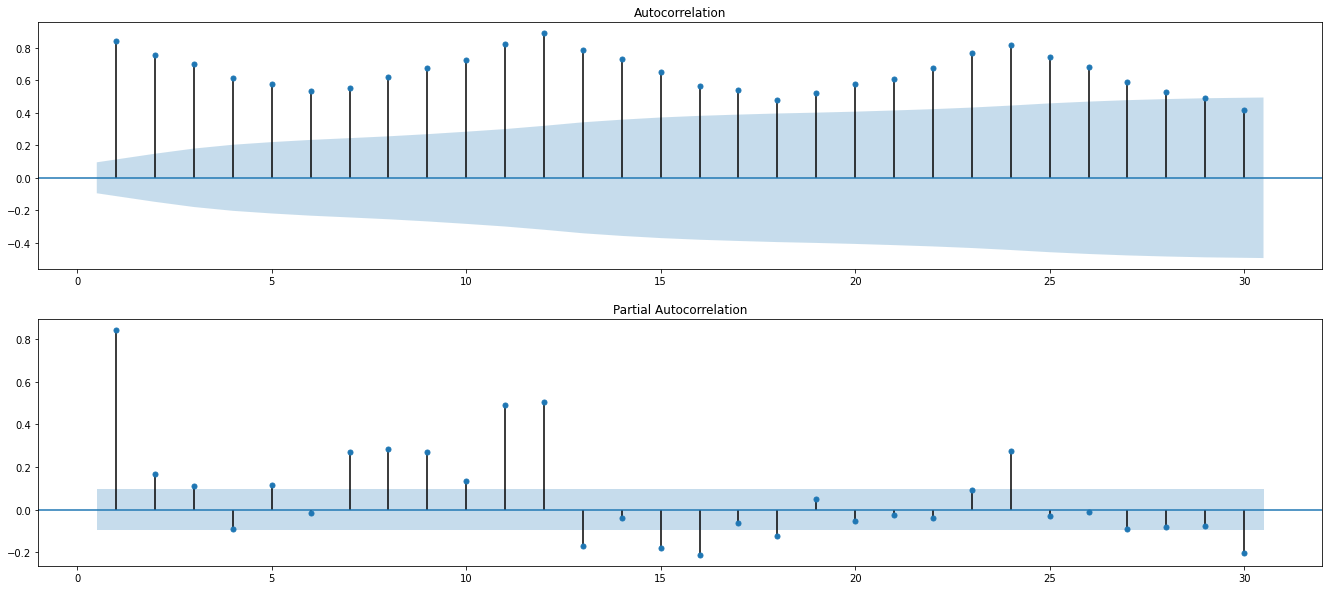

In [ ]:
# On se propose de regarder les sorties ACF et PACF de notre série
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(23,10))
plot_acf(df, lags=30, zero=False, ax=ax1)
plot_pacf(df, lags=30, zero=False, ax=ax2)
plt.show()

In [ ]:
# Comme le montre la sortie ACF, une sortie ACF qui alterne entre croissance et décroissance en forme pyramidale nous indique une saisonnalité dans la série temporelle,
# avec des pics corrélés tous les k intervalles de temps (où k est la période saisonnière).

# Comme notre série est non stationnaire, (sortie ACF, test de Dickey-Fuller augmenté...) il nous faut la différencier pour être plus facilement modélisable

diff_df = df.diff().dropna()

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


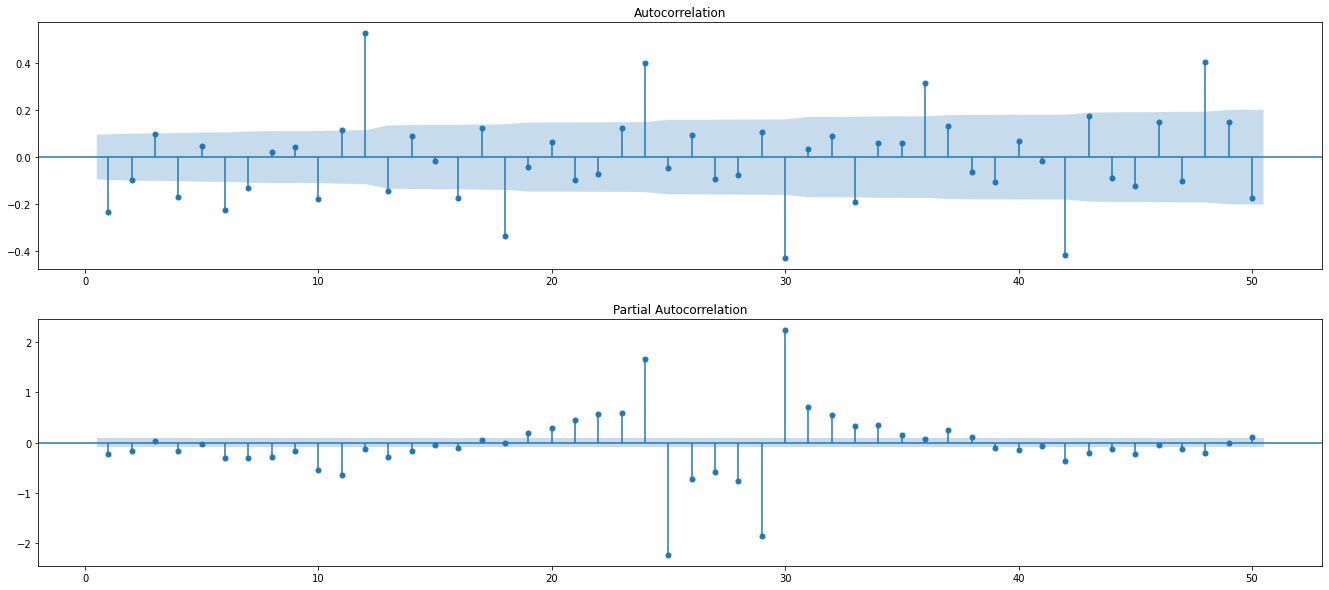

In [ ]:
# Maintenant qu'on a différencié, on se propose de regarder à nouveau les sorties ACF et PACF de notre série
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(23,10))
plot_acf(diff_df, lags=50, zero=False, ax=ax1)
plot_pacf(diff_df, lags=50, zero=False, ax=ax2)
plt.show()

In [ ]:
# On observe une assez forte chute vers le lag 25, comme il n'est pas évident de déterminer les paramètres exactes pour notre modèle SARIMA,
# on utilise la fonction sarima_grid_search qui permet d'effectuer une recherche exhaustive des meilleurs paramètres pour un modèle SARIMA donné

# La fonction prend en entrée une série temporelle, ainsi que des plages de valeurs pour les différents paramètres d'un modèle SARIMA
# (ordres de différenciation, ordres de la partie ARIMA, ordres de la saisonnalité, etc.).
# Elle teste ensuite toutes les combinaisons possibles de ces paramètres, et évalue la performance de chaque modèle obtenu en utilisant une méthode de validation croisée.

# Une fois que toutes les combinaisons ont été testées, la fonction renvoie les paramètres qui ont donné les meilleures performances sur la série temporelle fournie.
# Ces paramètres peuvent ensuite être utilisés pour entraîner un modèle SARIMA sur l'ensemble des données, et pour effectuer des prédictions sur de nouvelles observations.

# La recherche exhaustive des meilleurs paramètres est utile car elle permet de trouver la meilleure combinaison possible de paramètres pour un modèle SARIMA donné,
# ce qui peut nous permettre d'améliorer considérablement la qualité des prédictions sur la série temporelle en minimisant le AIC.


In [ ]:
diff_df

,PMBA
Mois,
1956-02-01,2.8
1956-03-01,-0.8
1956-04-01,-18.1
1956-05-01,-6.2
1956-06-01,-6.1
...,...
1990-10-01,60.3
1990-11-01,14.6
1990-12-01,-11.4


In [ ]:
# Avant de faire tourner notre grid search on crée nos futures échantillons de test/entrainement
# On considère les 3 dernières années comme entrainement

X = diff_df
start_date = '1956-02-01'
split_date = '1988-02-01'
X_train = X.loc[(X.index >= start_date) & (X.index <= split_date)].copy()
X_test = X.loc[X.index > split_date].copy()

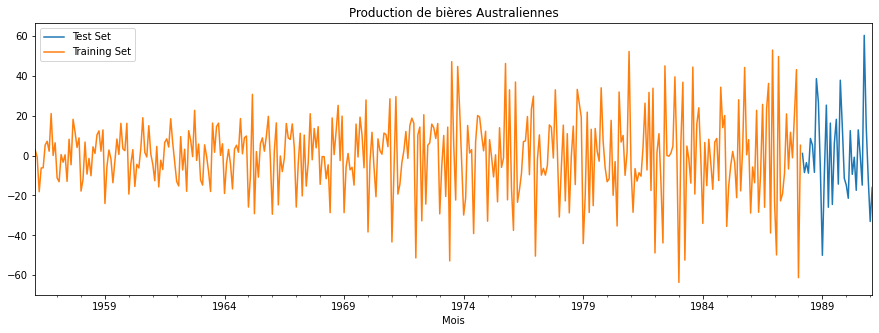

In [ ]:
# Visualisation training test sets sur échantillons test train -> après différenciation
X_test.rename(columns={'PMBA': 'Test Set'}) \
    .join(X_train.rename(columns={'PMBA': 'Training Set'}),how='outer') \
    .plot(figsize=(15,5), title='Production de bières Australiennes')
plt.show()

In [ ]:
# Recherche des paramètres optimaux pour un modèle SARIMA

def sarima_grid_search(data, s):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

    min_aic = float("inf")
    best_params = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(data, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit()
                if results.aic < min_aic:
                    min_aic = results.aic
                    best_params = (param, param_seasonal)
            except:
                continue

    return best_params

s = 12 # prévision à horizon de 12 mois
best_params = sarima_grid_search(diff_df, s)
print(f"Meilleurs paramètres : {best_params}")

In [ ]:
# Les meilleurs paramètres estimées sont : ((1, 0, 1), (0, 1, 1, 12))
# où (1, 0, 1) représente les paramètres de l'ordre ARIMA, avec : - 1 qui représente l'ordre de la différenciation,
#                                                                 - 0 représente l'ordre de l'autorégression et
#                                                                 - 1 représente l'ordre de la moyenne mobile
# où (0, 1, 1, 12) représente les paramètres saisonniers de l'ordre ARIMA, avec : - 0 représente l'ordre de l'autorégression saisonnièr,
#                                                                                 - 1 représente l'ordre de la différenciation saisonnière,
#                                                                                 - 1 représente l'ordre de la moyenne mobile saisonnière,
#                                                                                 - 12 représente la période saisonnière (mensuelle ici).
# Ainsi, le modèle SARIMA correspondant est un modèle SARIMA(0,1,1)(0,1,1,12).

In [ ]:
# Nous allons donc créer notre modèle SARIMA avec les paramètres estimés ci-dessus.

model = SARIMAX(X_train, order=best_params[0], seasonal_order=best_params[1], enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()
print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                               PMBA   No. Observations:                  385
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -1344.143
Date:                            Fri, 24 Feb 2023   AIC                           2696.285
Time:                                    20:56:54   BIC                           2711.819
Sample:                                02-01-1956   HQIC                          2702.462
                                     - 02-01-1988                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1884      0.043     -4.354      0.000      -0.273      -0.104
ma.L1         -0.8812      0.023   

In [ ]:
# On obtient au test de Jung-Box 0.58, ce résultat signifie que le modèle SARIMA a réussi à capturer la plupart des informations dans les données
# car il n'y a pas de preuve significative de corrélation des résidus dans le modèle. On peut suggèrer que le modèle est approprié pour la série temporelle

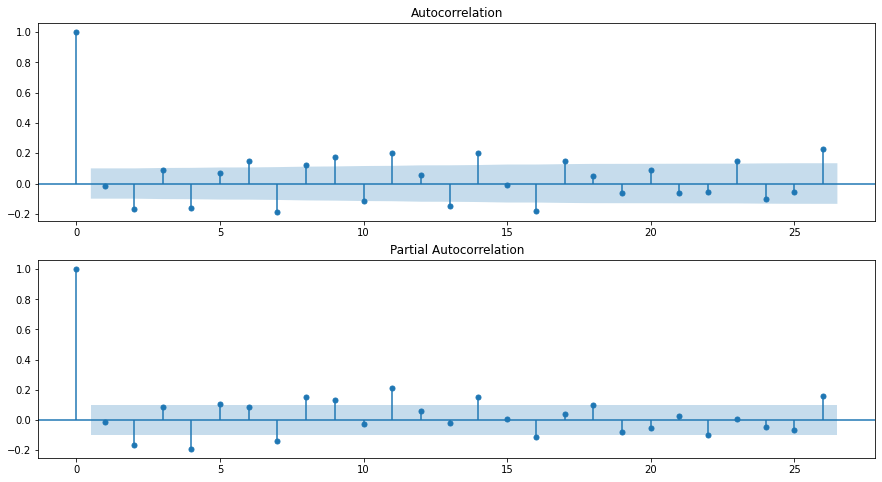

In [ ]:
res = results.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [ ]:
pred_sarima = results.predict("1988-03-01", "1991-02-01")
print('SARIMA model MSE:{}'.format(mean_squared_error(X_test.PMBA,pred_sarima)))

SARIMA model MSE:268.8673416247377


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


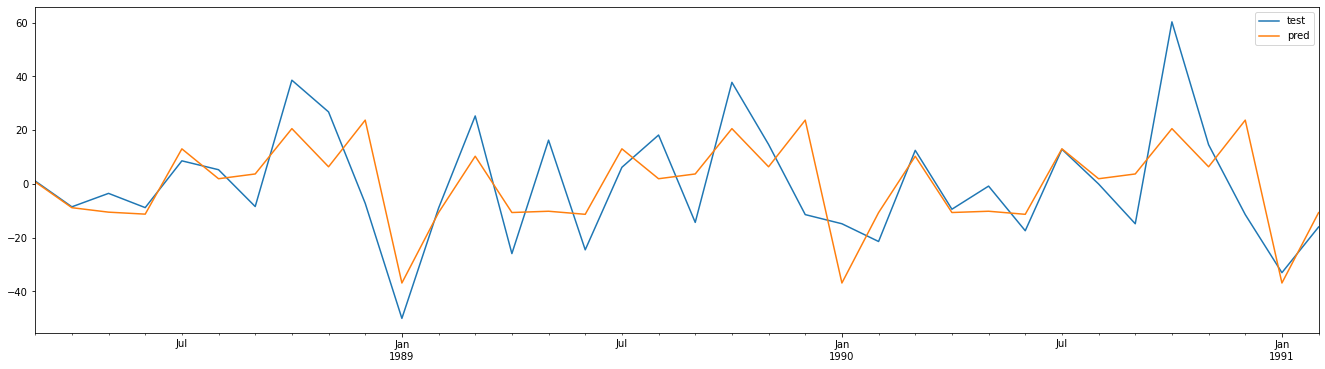

In [ ]:
pd.DataFrame({'test':X_test.PMBA,'pred':pred_sarima}).plot(figsize=(23,6))
plt.show()

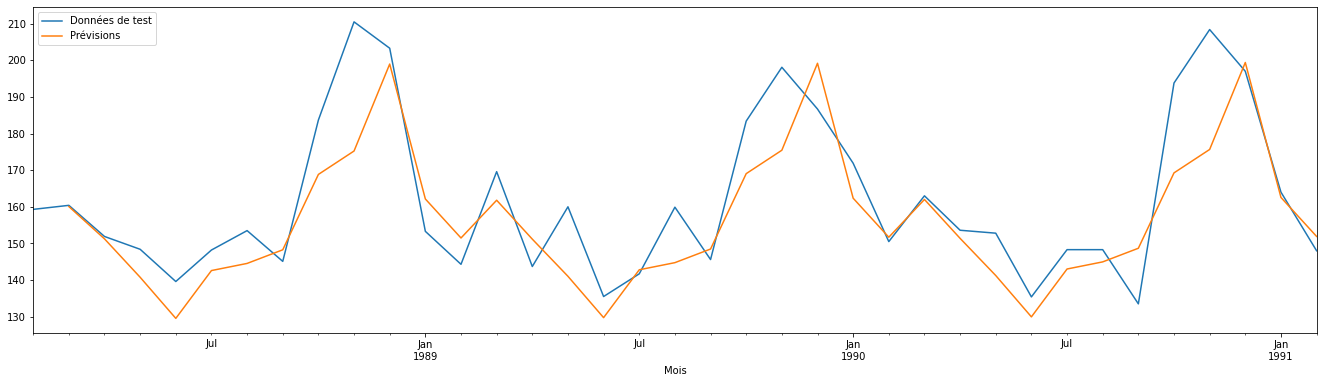

In [ ]:
# Calcul des prévisions sur les données d'entraînement
predicted_train = results.predict()

# Inversion de la différenciation sur les prévisions pour les données d'entraînement
cumsum_train = df['PMBA'].cumsum()
inverted_predicted_train = cumsum_train.loc[start_date] + predicted_train.cumsum()
inverted_predicted_train = pd.Series(inverted_predicted_train, index=X_train.index)

# Calcul des prévisions sur les données de test
predicted_test = results.get_forecast(steps=len(X_test)).predicted_mean

# Inversion de la différenciation sur les prévisions pour les données de test
cumsum_test = df['PMBA'].loc[split_date].cumsum()
inverted_predicted_test = cumsum_test + predicted_test.cumsum()
inverted_predicted_test = pd.Series(inverted_predicted_test, index=X_test.index)

# Comparaison des prévisions inversées avec les données de test
fig, ax = plt.subplots(figsize=(23, 6))
df['PMBA'].loc[split_date:].plot(ax=ax, label='Données de test')
inverted_predicted_test.plot(ax=ax, label='Prévisions')
plt.legend()
plt.show()


In [ ]:
# Quelques indicateurs de précision de notre modélisation

# Prédictions sur l'ensemble de test
y_pred = results.predict(start=X_test.index[0], end=X_test.index[-1])

# Vraies valeurs de l'ensemble de test
y_true = X_test.iloc[:, 0]

# Calcul des métriques
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# Affichage des résultats
print('MAE:', mae)
print('R2:', r2)
print('MSE:', mse)


MAE: 12.513249425996577
R2: 0.4180998399368101
MSE: 268.8673416247377


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


**Prédiction à un horizon 1 an**

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


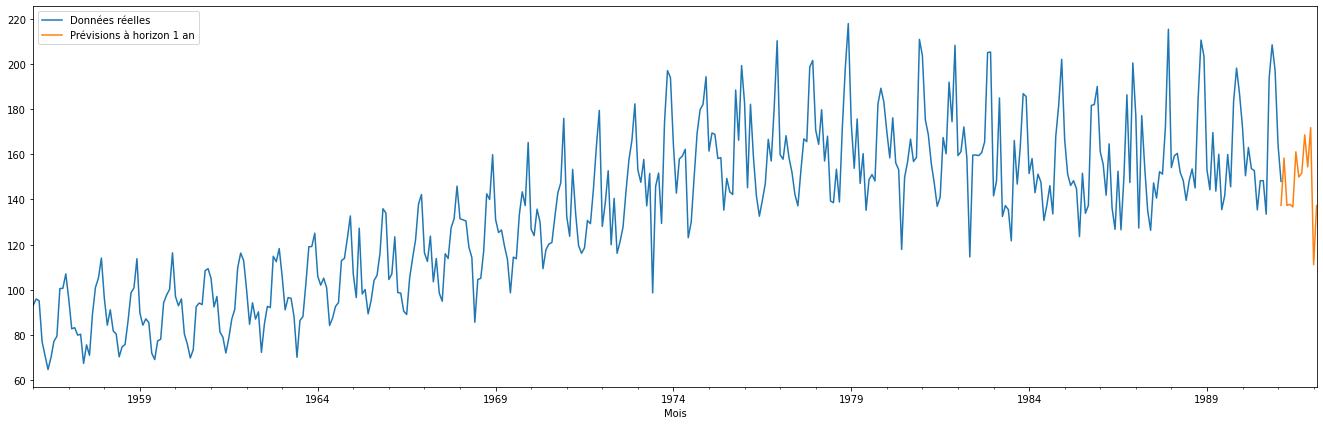

In [ ]:
# On cherche maintenant à prédire à horizon 1 an
# Prédiction future à horizon 1 an
pred_futures = results.predict("1991-02-01", "1992-02-01")

# On ajoute la dernière valeur observée de notre série temporelle à chacune de nos observations
last_value = df.iloc[-1]['PMBA']
pred_futures = pred_futures + last_value

# On crée notre dataframe
future_df = pd.DataFrame(index=future_dates, columns=['PMBA'])

# On ajoute les prédictions dans notre dataframe
future_df['PMBA'] = pred_futures

# Tracer les prévisions et les données réelles
fig, ax = plt.subplots(figsize=(23, 7))
df['PMBA'].plot(ax=ax, label='Données réelles')
pred_futures.plot(ax=ax, label='Prévisions à horizon 1 an')
plt.legend()
plt.show()

# Projet 2

In [ ]:
# Dans un premier temps, on se propose de chargées nos données dans un DataFrame, afin de visualiser à quoi ressemblent nos données.

df = pd.read_csv("ozone_complet.txt", sep  = ';')

In [ ]:
# Notre dataframe représente 1464 observations journalières, du 01/04/1995 au 30/09/2002, à Rennes
# On remet les dates sous un format propre

df.index = pd.to_datetime(df.index, format ='%Y%m%d')
# On se créer une nouvelle variable Data qui stock les valeurs de l'index puisqu'on veut réanitialiser, on pourra le remettre plus tard pour la modélisation en série temporelle
df['Date'] = df.index
df = df.reset_index(drop=True)

In [ ]:
df

,maxO3,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,...,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3v,Date
0,47.6,10.1,11.6,13.3,13.6,12.2,8.0,8.0,8.0,8.0,...,4.0,300.0,4.0,340.0,4.0,20.0,4.0,-3.4641,62.2,1995-04-01
1,56.2,9.5,9.4,13.8,17.4,16.3,8.0,8.0,7.0,0.0,...,2.0,180.0,3.0,110.0,1.0,350.0,2.0,0.0000,47.6,1995-04-02
2,61.8,3.6,8.0,16.8,21.5,20.2,4.0,5.0,2.0,2.0,...,2.0,340.0,1.0,170.0,2.0,170.0,3.0,-0.3420,56.2,1995-04-03
3,50.8,9.5,10.5,11.4,12.2,11.4,8.0,7.0,7.0,7.0,...,4.0,350.0,3.0,350.0,3.0,350.0,4.0,-0.5209,61.8,1995-04-04
4,59.8,9.8,10.8,13.8,14.3,13.3,8.0,7.0,8.0,8.0,...,2.0,280.0,1.0,320.0,3.0,350.0,4.0,-0.9848,50.8,1995-04-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,76.0,7.0,13.7,17.0,17.9,15.3,4.0,7.0,8.0,7.0,...,4.0,330.0,5.0,330.0,6.0,330.0,3.0,-2.5000,79.0,2002-09-26
1460,79.0,10.2,11.5,18.3,20.0,17.1,9.0,9.0,2.0,6.0,...,2.0,120.0,1.0,90.0,3.0,100.0,2.0,0.8660,76.0,2002-09-27
1461,91.0,6.2,14.1,19.8,21.1,18.1,0.0,0.0,1.0,2.0,...,3.0,120.0,4.0,120.0,4.0,100.0,2.0,3.4641,79.0,2002-09-28
1462,89.0,8.1,14.8,20.4,22.0,18.4,4.0,5.0,5.0,4.0,...,4.0,130.0,5.0,130.0,4.0,140.0,1.0,3.8302,91.0,2002-09-29


In [ ]:
# La variable qu'on cherche à prédire à l'horizon d'un jour est la variable : maxO3 représentant  la concentration d’ozone
# On cherche dans un premier temps à prévoir cette concentration
# par l'utilisation d'un modèle de régression en considérant uniquement les variables météorologiques

# Commençons par traiter les données manquantes si il y en a:

df.isna().sum()

maxO3     73
T6         1
T9         1
T12        1
T15        1
T18        1
Ne6        2
Ne9        2
Ne12       2
Ne15       2
Ne18       5
Vdir6      1
Vvit6      1
Vdir9      1
Vvit9      1
Vdir12     1
Vvit12     1
Vdir15     1
Vvit15     1
Vdir18     1
Vvit18     1
Vx         1
maxO3v    73
dtype: int64

In [ ]:
# Nous avons environ 5% de valeurs manquantes pour la variable cible, on peut donc accepter de supprimer ces valeurs pour la suite

df = df.dropna()
df.shape

(1366, 24)

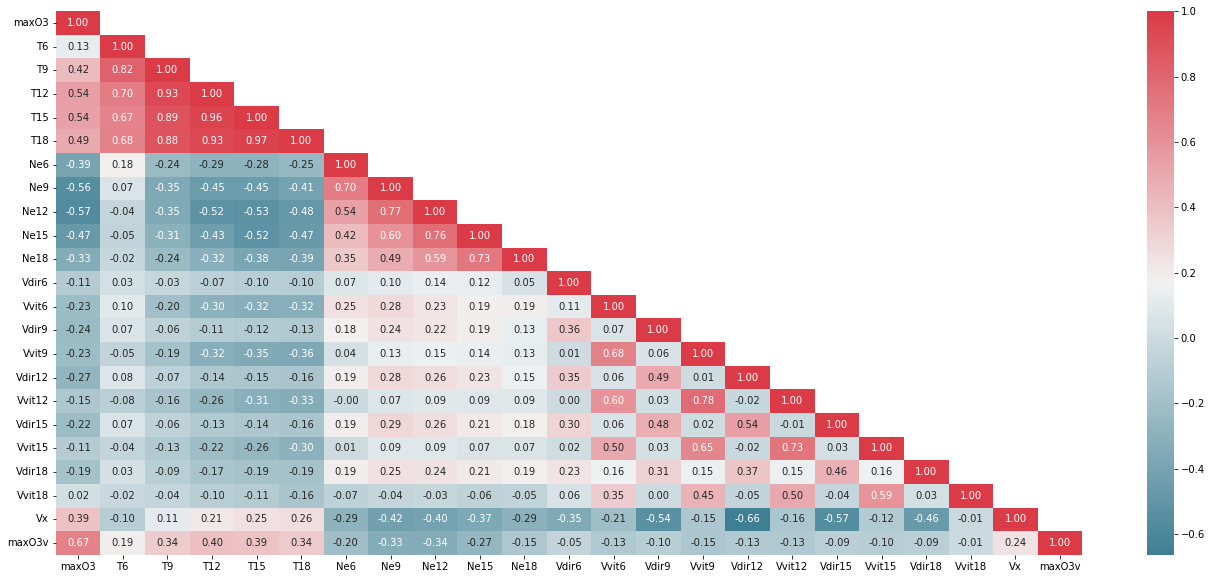

In [ ]:
# On peut regarder les différentes corrélations entre nos variables avant de passer à une modélisation quelconque

corr_matrix = df.corr()
plt.figure(figsize=(23,10))
dropSelf = np.zeros_like(corr_matrix)
dropSelf[np.triu_indices_from(dropSelf, k = 1)] = True

sns.heatmap(corr_matrix, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)

sns.set(font_scale=1.5)

In [ ]:
# On liste les variables les plus corrélées

# On récupère les colonne de notre matrice
columns = corr_matrix.columns

# On initialise note liste pour stocker les paires de correlation
highest_correlated_pairs = []

# On itere sur la mtrice et on recupère les coefficients
for i in range(len(columns)):
  for j in range(i+1, len(columns)):
    if abs(corr_matrix.iloc[i,j]) > 0.7:
      highest_correlated_pairs.append((columns[i], columns[j], corr_matrix.iloc[i,j]))

# On trie la liste par correlation les plus élevées
highest_correlated_pairs.sort(key=lambda x: -x[2])

f_corr = pd.DataFrame(highest_correlated_pairs, columns=['Column 1','Column 2','Correlation Coefficient'])

# On utilise background gradient pour donner de la couleur à notre graphe/sortie
f_corr.style.background_gradient(cmap = 'coolwarm')

f_corr.style.background_gradient(cmap = 'coolwarm').set_properties(**{'width': '100px', 'font-size': '10pt'}).set_caption('Highly correlated pairs')

,Column 1,Column 2,Correlation Coefficient
0,T15,T18,0.965651
1,T12,T15,0.960017
2,T12,T18,0.932588
3,T9,T12,0.930301
4,T9,T15,0.888180
5,T9,T18,0.880237
6,T6,T9,0.823754
7,Vvit9,Vvit12,0.778909
8,Ne9,Ne12,0.766747
9,Ne12,Ne15,0.762714


In [ ]:
# On décide de supprimer aléatoirement une des deux variables lorsque deux sont corrélées a plus de 0.7
# Peut être bien optimisé

print("Dimension avant traitement:", df.shape)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k =1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]
df_clean_corr = df.drop(df[to_drop], axis = 1)
print("Dimension après traitement:", df.shape)

# On stocke dans un autre dataframe pour comparer avec les résultats d'une prédiction sans traitement

Dimension avant traitement: (1366, 24)
Dimension après traitement: (1366, 24)


<ipython-input-101-b2cbc760015f>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k =1).astype(np.bool))


In [ ]:
# On compare avec les résultats sur un dataframe on a retiré les variables corrélées

X = df_clean_corr.drop(['maxO3','Date','maxO3v'], axis = 1).copy()
Y = df_clean_corr['maxO3'].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)
reg_LR = LinearRegression()
reg_LR.fit(X_train, Y_train)
Y_pred_LR = reg_LR.predict(X_test)

# On regarde les différents indicateurs de notre prédiction

mse = mean_squared_error(Y_test, Y_pred_LR)
mae = mean_absolute_error(Y_test, Y_pred_LR)
r2 = r2_score(Y_test, Y_pred_LR)
mape = np.mean(np.abs((Y_test - Y_pred_LR) / Y_test)) * 100

# où : - mse est l'erreur quadratique moyenne
#      - mae est l'erreur absolue moyenne
#      - R² est le coefficient de détermination
#      - mape est l'erreur absolue moyenne en pourcentage


print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R²: %.2f' % r2)
print('MAPE: %.2f%%' % mape)

MSE: 351.32
MAE: 14.69
R²: 0.43
MAPE: 18.10%


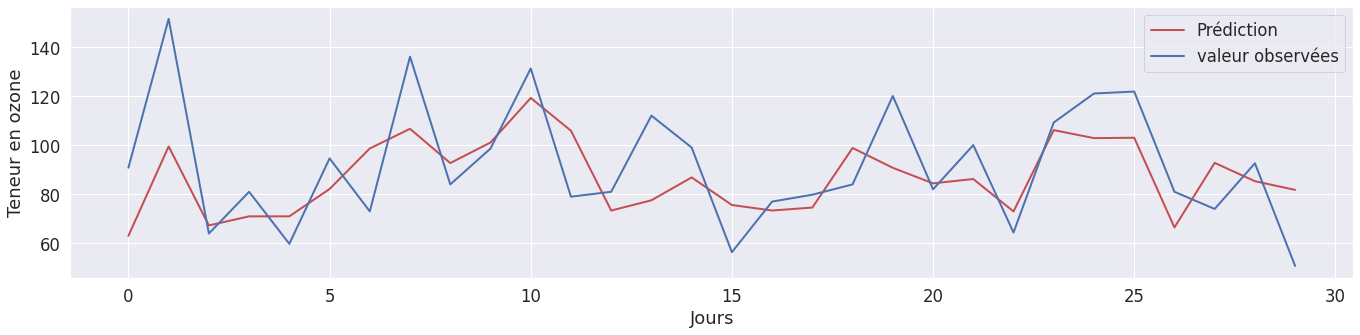

In [ ]:
# Affichage graphe prediction/ valeurs observées / au niveau journalier /
plt.figure(figsize=(23,5))
plt.plot(reg_LR.predict(X_test[-30:]), "r", label="Prédiction", linewidth=2.0)
plt.plot(Y_test.values[-30:], "b", label="valeur observées", linewidth=2.0)
plt.ylabel("Teneur en ozone")
plt.xlabel("Jours")
plt.legend(loc="best")

In [ ]:
# On sépare variable explicatives de la variable à prédire
# On retire les variables non météorologiques maxO3, maxO3v, Date

X = df.drop(['maxO3','Date','maxO3v'], axis = 1).copy()
Y = df['maxO3'].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)

# Régression Linéaire

reg_LR = LinearRegression()
reg_LR.fit(X_train, Y_train)
Y_pred_LR = reg_LR.predict(X_test)

# On regarde les différents indicateurs de notre prédiction

mse = mean_squared_error(Y_test, Y_pred_LR)
mae = mean_absolute_error(Y_test, Y_pred_LR)
r2 = r2_score(Y_test, Y_pred_LR)
mape = np.mean(np.abs((Y_test - Y_pred_LR) / Y_test)) * 100

# où : - mse est l'erreur quadratique moyenne
#      - mae est l'erreur absolue moyenne
#      - R² est le coefficient de détermination
#      - mape est l'erreur absolue moyenne en pourcentage


print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R²: %.2f' % r2)
print('MAPE: %.2f%%' % mape)

MSE: 290.25
MAE: 13.19
R²: 0.53
MAPE: 16.50%


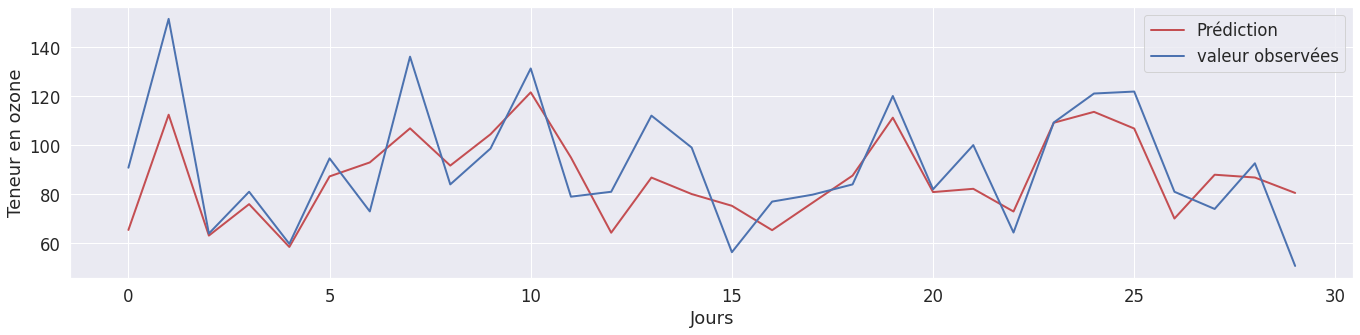

In [ ]:
# Affichage graphe prediction/ valeurs observées / au niveau journalier /
plt.figure(figsize=(23,5))
plt.plot(reg_LR.predict(X_test[-30:]), "r", label="Prédiction", linewidth=2.0)
plt.plot(Y_test.values[-30:], "b", label="valeur observées", linewidth=2.0)
plt.ylabel("Teneur en ozone")
plt.xlabel("Jours")
plt.legend(loc="best")

In [ ]:
# On remarque que les résultats sont meilleurs, c'est assez logique car l'enlèvemennt des variables a été fait aléatoirement, on aurait pu passer par une PCA
# mais le but ici n'est pas de trop optimiser

In [ ]:
# Les indicateurs indiquent cependant que notre modèle de régression linéaire ne prédit pas très bien la teneur maximale en ozone,
# car le MSE et le MAE sont élevés et le R² est faible. On peut supposer que la série temporelle contient des tendances
# et des saisons qui ne sont pas capturées par le modèle de régression linéaire.
# On va essayer d'utiliser d'autres modèles de régression plus sophistiqués pour améliorer la précision des prédictions.

In [ ]:
# On sépare variable explicatives de la variable à prédire
# On retire les variables non météorologiques maxO3, maxO3v, Date

X = df.drop(['maxO3','Date','maxO3v'], axis = 1).copy()
Y = df['maxO3'].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)

# On essaye XGBoost

reg_XGB = XGBRegressor()
reg_XGB.fit(X_train, Y_train)
Y_pred_XGB = reg_XGB.predict(X_test)

# On regarde les différents indicateurs de notre prédiction

mse = mean_squared_error(Y_test, Y_pred_XGB)
mae = mean_absolute_error(Y_test, Y_pred_XGB)
r2 = r2_score(Y_test, Y_pred_XGB)
mape = np.mean(np.abs((Y_test - Y_pred_LR) / Y_test)) * 100

# où : - mse est l'erreur quadratique moyenne
#      - mae est l'erreur absolue moyenne
#      - R² est le coefficient de détermination
#      - mape est l'erreur absolue moyenne en pourcentage


print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R²: %.2f' % r2)
print('MAPE: %.2f%%' % mape)

[22:21:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 232.06
MAE: 11.86
R²: 0.62
MAPE: 16.50%


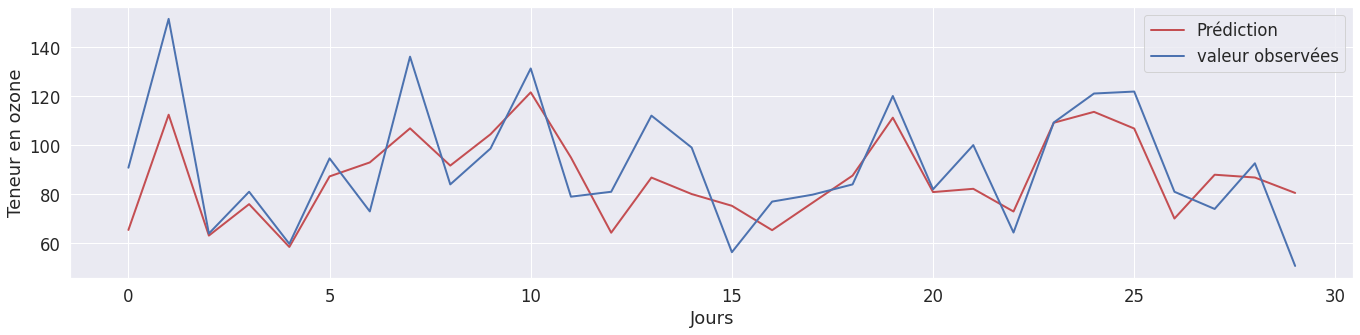

In [ ]:
# Affichage graphe prediction/ valeurs observées / au niveau journalier /
plt.figure(figsize=(23,5))
plt.plot(reg_LR.predict(X_test[-30:]), "r", label="Prédiction", linewidth=2.0)
plt.plot(Y_test.values[-30:], "b", label="valeur observées", linewidth=2.0)
plt.ylabel("Teneur en ozone")
plt.xlabel("Jours")
plt.legend(loc="best")

In [ ]:
# On obtient de bien meilleurs résultats après avoir essayé notre modèle XGBoost

# Essayons maintenant les 2 mêmes régressions en utilisant une séléction de variables (Recursive Feature Elimination)

Selector1 = RFECV(
    estimator = LinearRegression(),
    min_features_to_select = 2,
    step = 1,
    n_jobs=-1,
    cv = 5,
    scoring ='neg_mean_squared_error'
)

Selector_LinearReg = Selector1.fit(X_train, Y_train)

Selector2 = RFECV(
    estimator = XGBRegressor(),
    min_features_to_select = 2,
    step = 1,
    n_jobs=-1,
    cv = 5,
    scoring ='neg_mean_squared_error'
)

Selector_XGBoostReg = Selector2.fit(X_train, Y_train)

[23:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:33:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# On récupère nos variables séléctionnés

features_Linear_RFECV = X_train.columns[Selector_LinearReg.support_]
features_XGB_RFECV = X_train.columns[Selector_XGBoostReg.support_]

In [ ]:
# On affiche les variables choisies par RFECV -> LinearReg
features_Linear_RFECV

Index(['T6', 'T12', 'T15', 'T18', 'Ne9', 'Ne12', 'Vvit6', 'Vvit9', 'Vvit18',
       'Vx'],
      dtype='object')

In [ ]:
# On affiche les variables choisies par RFECV -> XGBRegressor
features_XGB_RFECV

Index(['T6', 'T12', 'T15', 'T18', 'Ne9', 'Ne12', 'Ne15', 'Ne18', 'Vvit9',
       'Vdir12', 'Vvit18', 'Vx'],
      dtype='object')

In [ ]:
X_train_selected_Linear = X_train[features_Linear_RFECV]
X_test_selected_Linear = X_test[features_Linear_RFECV]
X_train_selected_XGB = X_train[features_XGB_RFECV]
X_test_selected_XGB = X_test[features_XGB_RFECV]

In [ ]:
# On refait tourner nos modèles


# Régression Linéaire

reg_LR = LinearRegression()
reg_LR.fit(X_train_selected_Linear, Y_train)
Y_pred_LR = reg_LR.predict(X_test_selected_Linear)

# On regarde les différents indicateurs de notre prédiction

mse = mean_squared_error(Y_test, Y_pred_LR)
mae = mean_absolute_error(Y_test, Y_pred_LR)
r2 = r2_score(Y_test, Y_pred_LR)
mape = np.mean(np.abs((Y_test - Y_pred_LR) / Y_test)) * 100

# où : - mse est l'erreur quadratique moyenne
#      - mae est l'erreur absolue moyenne
#      - R² est le coefficient de détermination
#      - mape est l'erreur absolue moyenne en pourcentage


print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R²: %.2f' % r2)
print('MAPE: %.2f%%' % mape)

MSE: 286.35
MAE: 13.20
R²: 0.53
MAPE: 16.53%


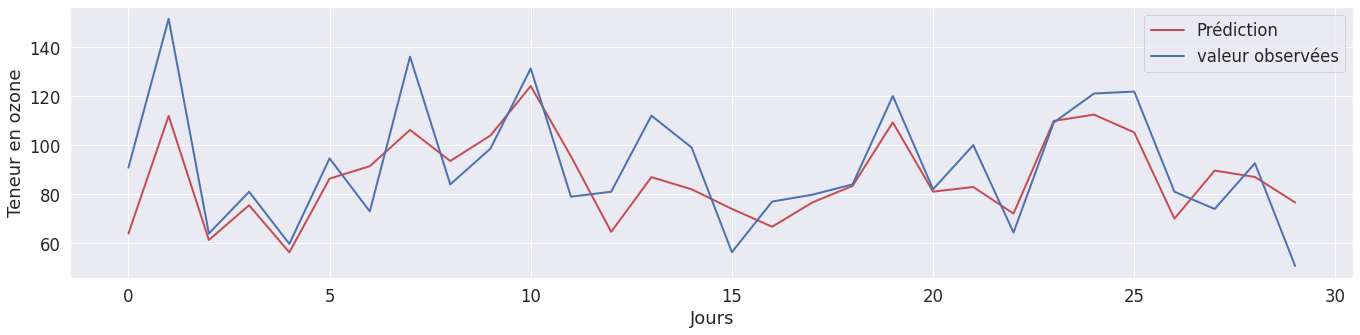

In [ ]:
# Affichage graphe prediction/ valeurs observées / au niveau journalier /
plt.figure(figsize=(23,5))
plt.plot(reg_LR.predict(X_test_selected_Linear[-30:]), "r", label="Prédiction", linewidth=2.0)
plt.plot(Y_test.values[-30:], "b", label="valeur observées", linewidth=2.0)
plt.ylabel("Teneur en ozone")
plt.xlabel("Jours")
plt.legend(loc="best")

In [ ]:
# On essaye XGBoost

reg_XGB = XGBRegressor()
reg_XGB.fit(X_train_selected_XGB, Y_train)
Y_pred_XGB = reg_XGB.predict(X_test_selected_XGB)

# On regarde les différents indicateurs de notre prédiction

mse = mean_squared_error(Y_test, Y_pred_XGB)
mae = mean_absolute_error(Y_test, Y_pred_XGB)
r2 = r2_score(Y_test, Y_pred_XGB)
mape = np.mean(np.abs((Y_test - Y_pred_LR) / Y_test)) * 100

# où : - mse est l'erreur quadratique moyenne
#      - mae est l'erreur absolue moyenne
#      - R² est le coefficient de détermination
#      - mape est l'erreur absolue moyenne en pourcentage


print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R²: %.2f' % r2)
print('MAPE: %.2f%%' % mape)

[23:36:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 237.58
MAE: 12.08
R²: 0.61
MAPE: 16.53%


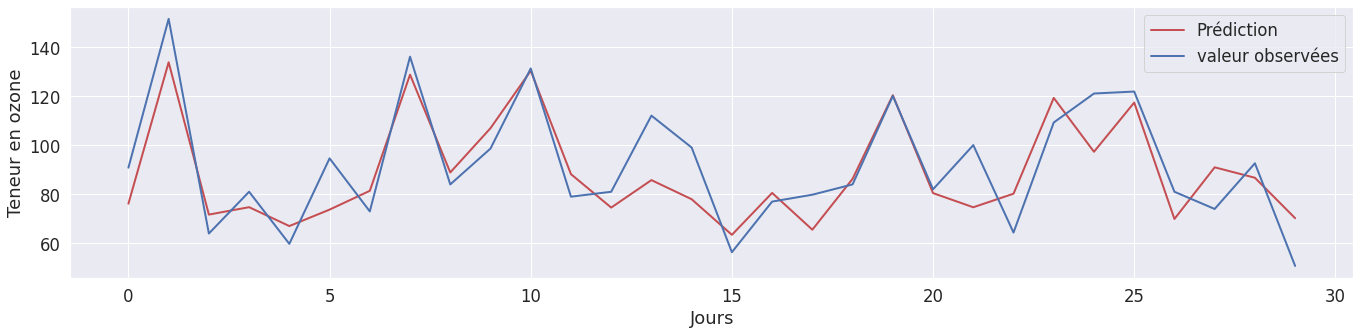

In [ ]:
# Affichage graphe prediction/ valeurs observées / au niveau journalier / 30 derniers jours
plt.figure(figsize=(23,5))
plt.plot(reg_XGB.predict(X_test_selected_XGB[-30:]), "r", label="Prédiction", linewidth=2.0)
plt.plot(Y_test.values[-30:], "b", label="valeur observées", linewidth=2.0)
plt.ylabel("Teneur en ozone")
plt.xlabel("Jours")
plt.legend(loc="best")

In [ ]:
# Les résultats sont stables avec deux fois de variables, mais il serait judicieux de regarder du côté des colinéarités si on souhaitait améliorer notre qualité de modèle.

2) On considère les variables météorologiques et le pic d'ozone de la veille

In [ ]:
# Essayons maintenant en considérant les variables météorologiques et le pic d'ozone de la veille

# On sépare variable explicatives de la variable à prédire
# On retire les variables maxO3, Date
# On garde la variable max03v

X = df.drop(['maxO3','Date'], axis = 1).copy()
Y = df['maxO3'].copy()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 42)

# Régression Linéaire

reg_LR = LinearRegression()
reg_LR.fit(X_train, Y_train)
Y_pred_LR = reg_LR.predict(X_test)

# On regarde les différents indicateurs de notre prédiction

mse = mean_squared_error(Y_test, Y_pred_LR)
mae = mean_absolute_error(Y_test, Y_pred_LR)
r2 = r2_score(Y_test, Y_pred_LR)
mape = np.mean(np.abs((Y_test - Y_pred_LR) / Y_test)) * 100

# où : - mse est l'erreur quadratique moyenne
#      - mae est l'erreur absolue moyenne
#      - R² est le coefficient de détermination
#      - mape est l'erreur absolue moyenne en pourcentage


print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R²: %.2f' % r2)
print('MAPE: %.2f%%' % mape)

MSE: 196.94
MAE: 10.77
R²: 0.68
MAPE: 13.76%


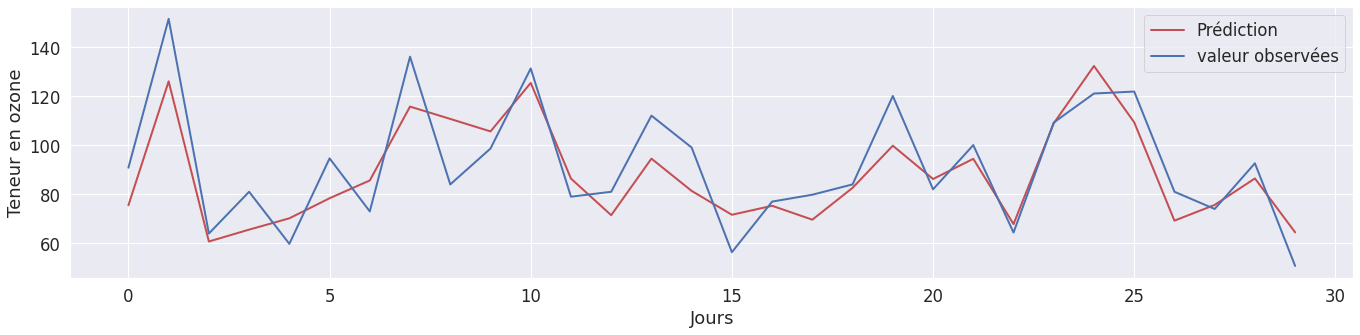

In [ ]:
# Affichage graphe prediction/ valeurs observées / au niveau journalier / 30 derniers jours
plt.figure(figsize=(23,5))
plt.plot(reg_LR.predict(X_test[-30:]), "r", label="Prédiction", linewidth=2.0)
plt.plot(Y_test.values[-30:], "b", label="valeur observées", linewidth=2.0)
plt.ylabel("Teneur en ozone")
plt.xlabel("Jours")
plt.legend(loc="best")

In [ ]:
# On observe une large amélioration avec l'ajout de cette seule variable ! On regarde pour notre second modèle

# On essaye XGBoost

reg_XGB = XGBRegressor()
reg_XGB.fit(X_train, Y_train)
Y_pred_XGB = reg_XGB.predict(X_test)

# On regarde les différents indicateurs de notre prédiction

mse = mean_squared_error(Y_test, Y_pred_XGB)
mae = mean_absolute_error(Y_test, Y_pred_XGB)
r2 = r2_score(Y_test, Y_pred_XGB)
mape = np.mean(np.abs((Y_test - Y_pred_LR) / Y_test)) * 100

# où : - mse est l'erreur quadratique moyenne
#      - mae est l'erreur absolue moyenne
#      - R² est le coefficient de détermination
#      - mape est l'erreur absolue moyenne en pourcentage


print('MSE: %.2f' % mse)
print('MAE: %.2f' % mae)
print('R²: %.2f' % r2)
print('MAPE: %.2f%%' % mape)

[23:37:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE: 168.91
MAE: 9.72
R²: 0.72
MAPE: 13.76%


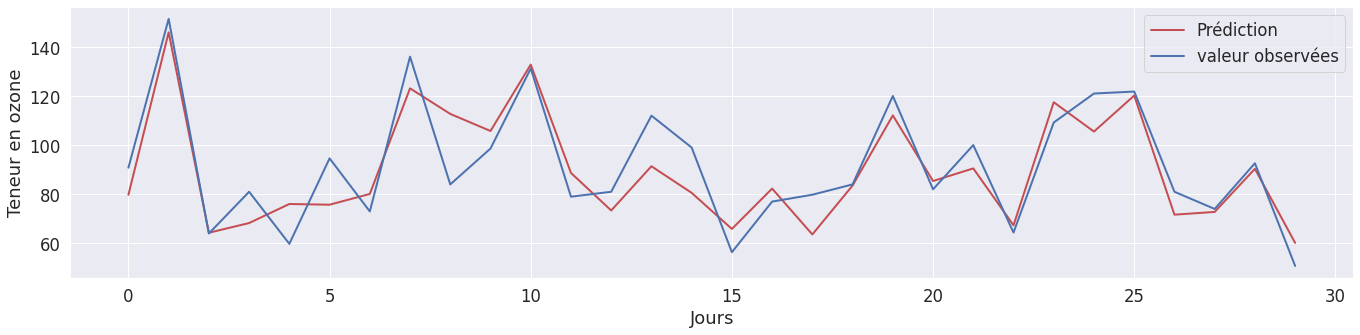

In [ ]:
# Affichage graphe prediction/ valeurs observées / au niveau journalier / 30 derniers jours
plt.figure(figsize=(23,5))
plt.plot(reg_XGB.predict(X_test[-30:]), "r", label="Prédiction", linewidth=2.0)
plt.plot(Y_test.values[-30:], "b", label="valeur observées", linewidth=2.0)
plt.ylabel("Teneur en ozone")
plt.xlabel("Jours")
plt.legend(loc="best")

In [ ]:
# La grande amélioration de nos prédictions dû au simple fait de l'ajout de la variable du pic d'ozone de la veille
# nous suggère la présence d'une certaine structure temporelle dans les données.
# Dans ce cas, l'utilisation d'un modèle de série temporelle nous serait justifié.
# Et cela serait encore plus justifié, car nous savons que la teneur en ozone dans notre atmosphère dépend des saisons, et donc
# un modèle de régression standard ne pourrait prendre en compte ces variations saisonnières.